In [224]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.stats import circmean, circstd, mode

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap
import taylorDiagram

from numpy.fft import fft, ifft
import astropy.stats.circstats as astro_circstats

import diurnal_config

from diurnal_utils import *
from fetch_model_helper import *

%run cmip_metrics.py
%run model_by_model_analysis_helper.py

import matplotlib 

font = {'weight' : 'bold',
        'size'   : 13}
label_fontdict = {'weight' : 'bold',
        'size'   : 13}
title_fontdict = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

FLUX_TO_MM_HR = 60*60
FLUX_TO_MM_YR = FLUX_TO_MM_HR*24*365
HOURS_TO_RADIANS = 2*np.pi/24

In [225]:
rel_data_dir = '/export/data1/cchristo/'
save_figs_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/'

input_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5_regridded/grid1/' #GFDL-ESM2M/'
input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_regridded/grid1/' #GFDL-ESM4/'
input_data_dir_gpm = rel_data_dir  + 'diurnal_analysis_results/GPM_regridded/grid1/GPM/'
land_sea_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_regridded/grid1/grid1_GLDASp4_landmask_1d.nc'

input_data_dir_rlut = '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rlut/'
input_data_dir_rsut = '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rsut/' 

In [226]:
os.listdir(input_data_dir_gpm)

['grid1_2000-06_2010-06_precip.nc']

In [227]:
rel_cmip6_path= '/export/data1/cchristo/CMIP6_precip/pr_3hr_historical/'
rel_cmip5_path = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'

unique_cmip6_models = list(get_unique_models(rel_cmip6_path))
unique_cmip5_models = list(get_unique_models(rel_cmip5_path))

In [228]:

ds_land_sea = xr.open_dataset(land_sea_mask)
df_land_sea = ds_land_sea.to_dataframe().astype(int)
# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']




In [129]:
# ds_gpm['phase_season']

## Take mean accross seasons for GPM (circular for phase!)

In [229]:
ds_gpm = xr.open_dataset(input_data_dir_gpm +  'grid1_2000-06_2010-06_precip.nc') #.mean(dim = 'season')
# take mean across seasons using circular mean for phase
ds_gpm_phase_year_mean = xr.apply_ufunc(circmean, ds_gpm['phase_season'], 
                                   kwargs = {'low' : 0.0, 'high' : 24.0},
                                   input_core_dims=[["season"]], 
                                   vectorize = True)
ds_gpm = ds_gpm.mean(dim = 'season')
ds_gpm['phase_season'] = ds_gpm_phase_year_mean
ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
df_gpm = ds_gpm.to_dataframe()

df_gpm_land = df_gpm[df_gpm['land_sea_mask'] == 1]
df_gpm_water= df_gpm[df_gpm['land_sea_mask'] == 0]

In [230]:
def _merge_models_into_df(model_names, input_data_dir,
                          filename = '1985-01_2006-01_precip.nc',
                          compute_year_mean_bool = False, 
                          verbose = False):
    '''Given list of model names and path to cmip files containing seasonal components, 
    open and take yearly mean (ensuring a circular mean is used for phase).'''
    objs = {}
    df = pd.DataFrame()
    for model_name_i in range(len(model_names)):  
        try:
            model_name = model_names[model_name_i]
            path_to_file = input_data_dir + model_name + '/' + filename
            ds_i = xr.open_dataset(path_to_file)
            if compute_year_mean_bool:
                ds_i_phase_year_mean = xr.apply_ufunc(circmean, ds_i['phase_season'], 
                                   kwargs = {'low' : 0.0, 'high' : 24.0},
                                   input_core_dims=[["season"]], 
                                   vectorize = True,
                                   dask = 'allowed')
                ds_i = ds_i.mean(dim = 'season')
                ds_i['phase_season'] = ds_i_phase_year_mean
            objs[model_names[model_name_i]] = ds_i.to_dataframe()
            objs[model_names[model_name_i]]['model_name'] = model_name
        
        except Exception as e:
            if verbose:
                print('Could not get ', model_name_i, ' : ', e)
    df = pd.concat(list(objs.values()), axis = 0)
    return df
    

In [ ]:
%%time
# # compute yearly mean
# df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
#                                input_data_dir = input_data_dir_cm6, 
#                                filename = 'grid1_1985-01_2006-01_precip.nc', 
#                                compute_year_mean_bool = True,
#                                verbose = False)
# use only one season 
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                               compute_year_mean_bool = False,
                               verbose = False)

df_cm6['cmip_indentifier'] = 'CMIP6'

# df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
#                                input_data_dir = input_data_dir_cm5,
#                               filename = 'grid1_1985-01_2006-01_precip.nc', 
#                               compute_year_mean_bool = True,
#                               verbose = False)
# df_cm5['cmip_indentifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,) #.reset_index('season')

# use only cmip6
df_models = df_cm6.copy()

# merge land/sea mask
df = pd.merge(df_models, df_land_sea, how = 'left', left_index = True, right_index = True)
# df = df.reset_index('season')
df = df.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

In [158]:
# ys
# ds_i.to_dataframe

# list(objs.values())[0]
# df
# ds_gpm['phase_season'].isel(season = 3).plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)

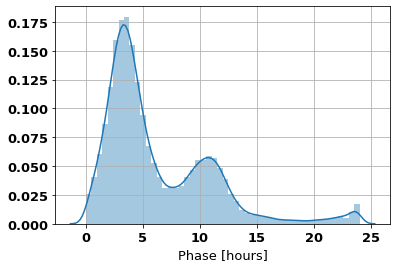

In [232]:
# df[df['model_name'] == 'GFDL-CM4'].plot(y = 'phase_season', kind = 'hist', bins = 30)
sns.distplot(df[df['model_name'] == 'GFDL-CM4']['phase_season'].values)
plt.xlabel('Phase [hours]')
plt.grid()



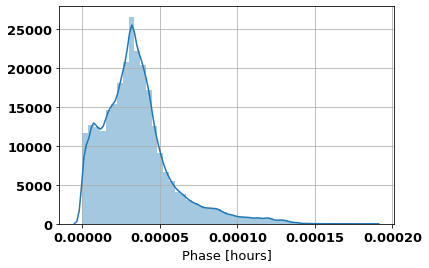

In [12]:
sns.distplot(df[df['model_name'] == 'GFDL-CM4']['mu_season'].values)
plt.xlabel('Phase [hours]')
plt.grid()

2.6193638396735426


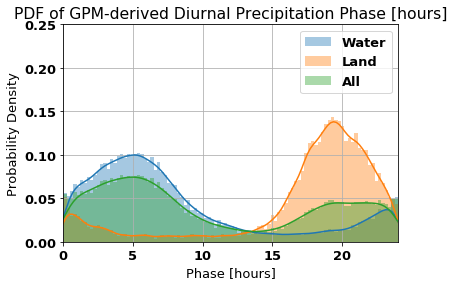

In [141]:
sns.distplot(df_gpm[df_gpm['land_sea_mask'] == 0]['phase_season'].values, label = 'Water', bins = 100)
sns.distplot(df_gpm[df_gpm['land_sea_mask'] == 1]['phase_season'].values, label = 'Land', bins = 100)
sns.distplot(df_gpm['phase_season'].values, label = 'All', bins = 100)
print(phase_circmean(df_gpm['phase_season']))
plt.xlim([0, 24])
plt.ylim([0, 0.25])
plt.xlabel('Phase [hours]')
plt.ylabel('Probability Density')
plt.title('PDF of GPM-derived Diurnal Precipitation Phase [hours]')
plt.grid()
plt.legend()
# plt.savefig(save_figs_dir + 'GPM/' + 'phase_pdf_land_ocean.png', dpi = 300)

In [172]:
mode(np.round(df_gpm[df_gpm['land_sea_mask'] == 1]['phase_season'].values,1))
# df_gpm[df_gpm['land_sea_mask'] == 1]['phase_season'].values

ModeResult(mode=array([19.]), count=array([687]))

In [173]:
np.round(df_gpm[df_gpm['land_sea_mask'] == 1]['phase_season'].values,1)

array([21. , 21.1, 21.1, ...,  4.9,  4.9,  4.9])

In [176]:
df_gpm[df_gpm['land_sea_mask'] == 1]['phase_season'].round(1).mode()

0    19.0
dtype: float64

In [163]:
# df_gpm[df_gpm['land_sea_mask'] == 1]['phase_season'].values
phase_circmean(df_gpm[df_gpm['land_sea_mask'] == 1]['phase_season'].values)

19.903311053920127

4.355335581184079


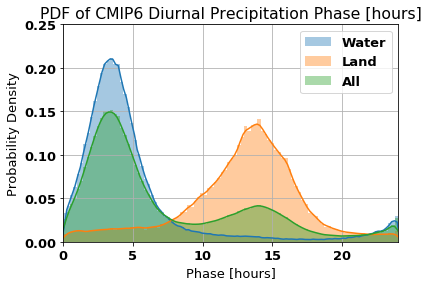

In [313]:
sns.distplot(df[(df['land_sea_mask'] == 0) & (df['cmip_indentifier'] == 'CMIP6')]['phase_season'].values, label = 'Water', bins = 100)
sns.distplot(df[(df['land_sea_mask'] == 1) & (df['cmip_indentifier'] == 'CMIP6')]['phase_season'].values, label = 'Land', bins = 100)
sns.distplot(df['phase_season'].values, label = 'All', bins = 100)
print(phase_circmean(df['phase_season']))

plt.xlim([0, 24])
plt.ylim([0, 0.25])
plt.xlabel('Phase [hours]')
plt.ylabel('Probability Density')
plt.title('PDF of CMIP6 Diurnal Precipitation Phase [hours]')
plt.grid()
plt.legend()
# plt.savefig(save_figs_dir + 'CMIP6/comparisions/' + 'phase_pdf_land_ocean.png', dpi = 300)

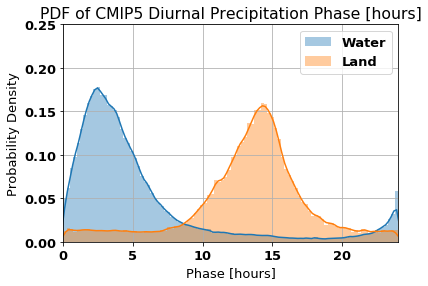

In [73]:
sns.distplot(df[(df['land_sea_mask'] == 0) & (df['cmip_indentifier'] == 'CMIP5')]['phase_season'].values, label = 'Water', bins = 100)
sns.distplot(df[(df['land_sea_mask'] == 1) & (df['cmip_indentifier'] == 'CMIP5')]['phase_season'].values, label = 'Land', bins = 100)
plt.xlim([0, 24])
plt.ylim([0, 0.25])
plt.xlabel('Phase [hours]')
plt.ylabel('Probability Density')
plt.title('PDF of CMIP5 Diurnal Precipitation Phase [hours]')
plt.grid()
plt.legend()
plt.savefig(save_figs_dir + 'CMIP5/comparisons/' + 'phase_pdf_land_ocean.png', dpi = 300)

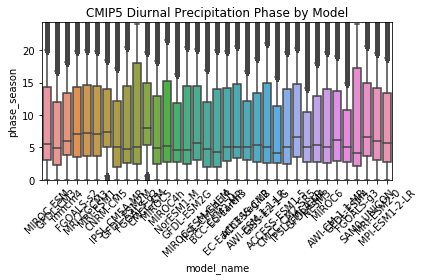

In [67]:
sns.boxplot(x = 'model_name', y = 'phase_season', data = df, whis = 0.5)
# sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('CMIP5 Diurnal Precipitation Phase by Model')
# plt.grid()
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_cmip5.png', dpi = 300)

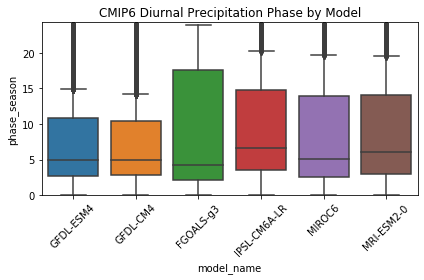

In [114]:
sns.boxplot(x = 'model_name', y = 'phase_season', data = df_cm6, whis = 0.5)
# sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('CMIP6 Diurnal Precipitation Phase by Model')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_cmip6.png', dpi = 300)

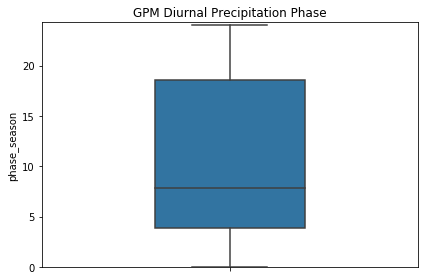

In [265]:

sns.boxplot(y = 'phase_season', data = df_gpm, whis = 0.5, width = 0.4)
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('GPM Diurnal Precipitation Phase')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_gpm.png', dpi = 300)

In [70]:
# df_cm6


In [74]:
# plt.figure(figsize = (8,5))
# sns.boxplot(x = 'model_name', y = 'phase_season', hue = 'land_sea_mask', data = df_cm6, whis = 0.5)
# # sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
# plt.ylim(0, 24.3)
# plt.xticks(rotation = 45)
# plt.title('CMIP6 Diurnal Precipitation Phase by Model [land/sea]')
# plt.tight_layout()
# plt.legend(loc  = 1)
# plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_land_sea_cmip6.png', dpi = 300)

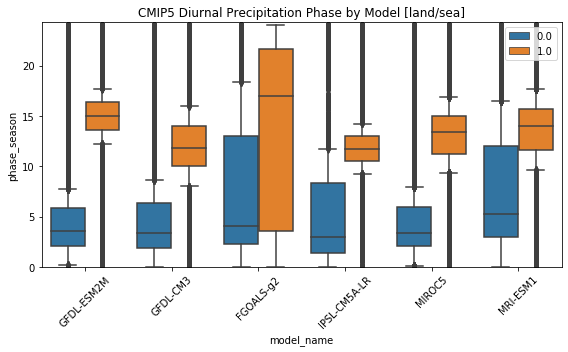

In [149]:
plt.figure(figsize = (8,5))
sns.boxplot(x = 'model_name', y = 'phase_season', hue = 'land_sea_mask', data = df_cm5, whis = 0.5)
# sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('CMIP5 Diurnal Precipitation Phase by Model [land/sea]')
plt.tight_layout()
plt.legend(loc  = 1)
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_land_sea_cmip5.png', dpi = 300)

In [159]:
# df_gpm
df_gpm['source'] = 'gpm'

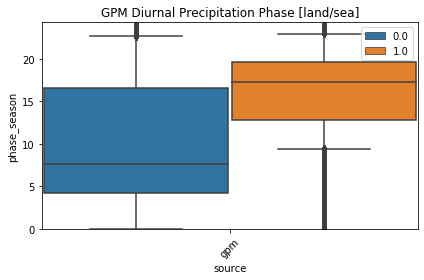

In [160]:

sns.boxplot(x = 'source', y = 'phase_season', data = df_gpm, whis = 0.5, hue = 'land_sea_mask', width = 1)
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('GPM Diurnal Precipitation Phase [land/sea]')
plt.tight_layout()
plt.legend(loc  = 1)
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_gpm_land_sea.png', dpi = 300)

In [28]:
# make_four_panel(ds , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
#                 vmin = 0, vmax = 24, 
#                 cmap = plt.get_cmap('twilight'),
#                 title = r'$\Phi$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= None)

In [135]:
# Important functions 

# def circdiff(A,B, max_val = 24.0):
#     '''Calculate absolute difference between two circular quantities '''
# #     A_rad, B_rad = A*HOURS_TO_RADIANS, B*HOURS_TO_RADIANS 
#     abs_diff =  max_val/2 - abs(abs(A - B) - max_val/2)
#     return abs_diff

# def circrmse(A, B, max_val = 24.0):
#     diff = circdiff(A, B, max_val = 24.0)
#     return np.sqrt((np.sum((diff)**2)/len(diff)))

# def phase_circmean(arr):
#     '''Use scipy circmean to calcualte circular mean of array of hours [0, 24]'''
#     return circmean(arr, low =  0.0, high = 24.0)
# # np.corrcoef
# # model_error_stats
# # plt.imshow(df_i[field].values * (2*np.pi/24), origin = 'lower')
# def sin_hour(hours):
#     '''Give array of hours, convert sin quanitity to deal with cirular quantity'''
#     return np.sin(hours*HOURS_TO_RADIANS)
# # df_i[field].values * HOURS_TO_RADIANS

# def ampl_weighted_mean_func(df):
#     return (df['precip_weights']*df['ampl_season']).sum()




In [106]:
# tests for circular stats functions above
# circrmse(np.array([23, 9]), np.array([1, 11]))

# compute error statistics


In [201]:
df_cmip6 = df[df['cmip_indentifier'] == 'CMIP6']
df_cmip5 = df[df['cmip_indentifier'] == 'CMIP5']
field = 'phase_season'
# season = 'DJF'
# df

df_for_stats = df_cmip6.copy()
df_for_stats_true = df_gpm.copy()

df_for_stats['ampl_season'] = FLUX_TO_MM_HR*df_for_stats['ampl_season']
df_for_stats['mu_season'] = FLUX_TO_MM_HR*df_for_stats['mu_season']
# df_for_stats = df_for_stats[df_for_stats['season'] == season]


# df_for_stats_true = df_gpm[df_gpm['season'] == season]

# compute precip weights
df_for_stats_true['precip_weights'] = df_for_stats_true['mu_season']/df_for_stats_true['mu_season'].sum()

# merge gpm precip weights into model df 
df_for_stats = pd.merge(df_for_stats, 
                        df_for_stats_true['precip_weights'], 
                        how = 'left', 
                        left_index = True, 
                        right_index = True)


df_lat_lon_mean = df_for_stats.groupby(['lat','lon']).mean()
# df_lat_lon_err = df_lat_lon_mean - df_for_stats_true
df_lat_lon_err = circdiff(df_lat_lon_mean, df_for_stats_true)
cmips_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err)
cmips_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)

ampl_weighted_mean_df = df_for_stats[['ampl_season', 'precip_weights', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

In [98]:
# df_for_stats

In [99]:

def phase_weighted_mean(df):
    return (df['precip_weights']*df['ampl_season']).sum()

In [53]:
(cmips_mean_ds['ampl_season'] * precip_weights).sum()

<xarray.DataArray ()>
array(0.04146962)

In [55]:
# cmips_mean_ds['ampl_season'].mean()

In [98]:
ds_gpm['mu_season'].mean() - cmips_mean_ds['mu_season'].mean()

<xarray.DataArray 'mu_season' ()>
array(0.13031464)

In [138]:
ds_land_sea['GLDAS_mask']

<xarray.DataArray 'GLDAS_mask' (lat: 240, lon: 720)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
  * lat      (lat) float64 -60.0 -59.5 -59.0 -58.5 -58.0 ... 58.0 58.5 59.0 59.5

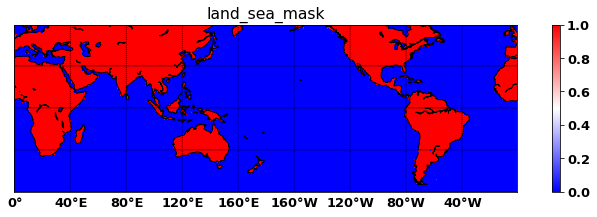

In [14]:
make_single_plot(ds_land_sea['GLDAS_mask'] ,
                 title = 'land_sea_mask',
                 vmin = 0, vmax = 1, 
                 cmap  =plt.get_cmap('bwr'))

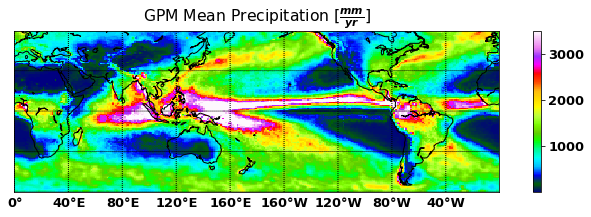

In [52]:
make_single_plot(ds_gpm['mu_season']*24*365, 
                 title = r'GPM Mean Precipitation [$\frac{mm}{yr}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24*365)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)

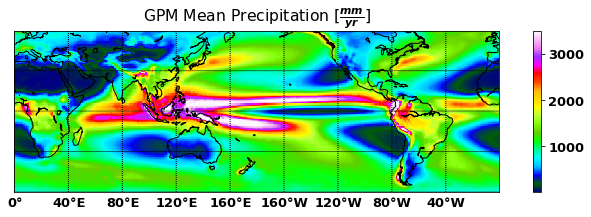

In [54]:
make_single_plot(cmips_mean_ds['mu_season']*24*365, 
                 title = r'GPM Mean Precipitation [$\frac{mm}{yr}$]',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24*365)
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'mu_mean_spatial.png', dpi = 300)

In [112]:
ds_gpm['mu_season'].mean() - cmips_mean_ds['mu_season'].mean()

<xarray.DataArray 'mu_season' ()>
array(0.00112189)

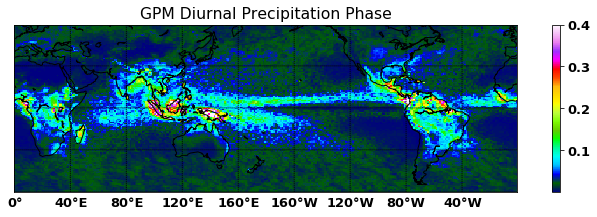

In [190]:
make_single_plot(ds_gpm['ampl_season'], 
                 title = r'GPM Diurnal Precipitation Amplitude',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)
# plt.savefig(save_figs_dir + 'GPM/' + 'ampl_mean_spatial.png', dpi = 300)

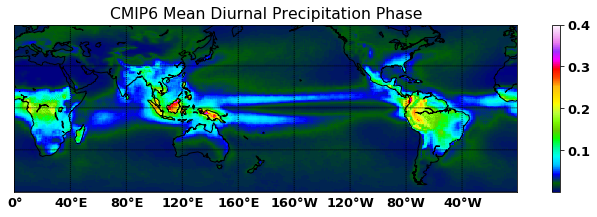

In [191]:
make_single_plot(cmips_mean_ds['ampl_season'], 
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'ampl_mean_spatial.png', dpi = 300)

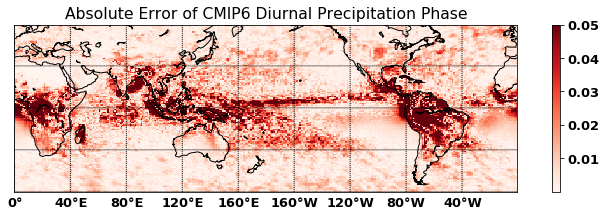

In [192]:
make_single_plot(cmips_err_ds['ampl_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'),vmax = 0.05)
# plt.savefig(save_figs_dir + 'compare_models/' + 'ampl_abs_error_spatial.png', dpi = 300)

In [282]:
%run diurnal_utils.py

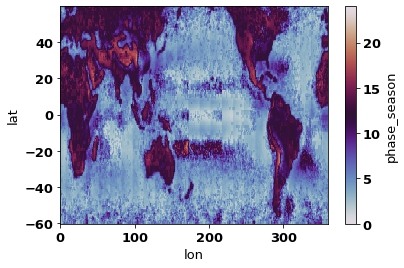

In [193]:
cmips_mean_ds[field].plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)
# (cmips_mean_ds[field]*10000).plot.imshow(cmap = plt.get_cmap('gist_ncar'))

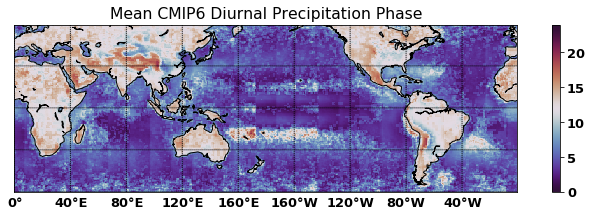

In [194]:
%run diurnal_utils.py
# cmips_mean_ds[field].values
make_single_plot(cmips_mean_ds['phase_season'], 
                 title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
# isinstance(cmips_mean_ds[field])
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'phase_mean_spatial.png', dpi = 300)

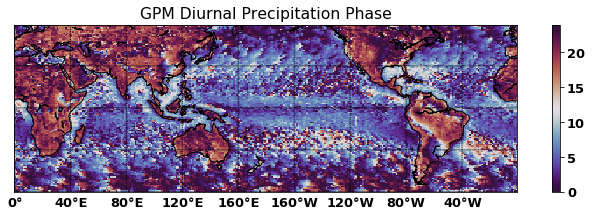

In [195]:
make_single_plot(ds_gpm['phase_season'], 
                 title = r'GPM Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
# plt.savefig(save_figs_dir + 'GPM/' + 'phase_mean_spatial.png', dpi = 300)
# ds_gpm[field].plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)
# ds_gpm[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'))

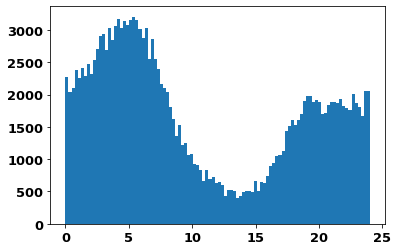

In [224]:
_ = plt.hist(ds_gpm['phase_season'].values.flatten(), bins = 100)

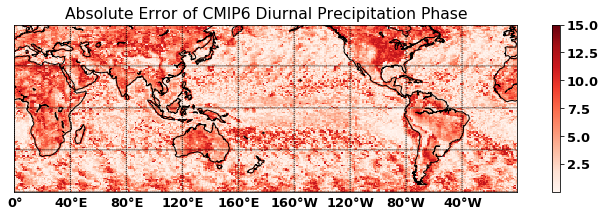

In [196]:
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'), vmin = -5, vmax = 5)
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('seismic_r'))
make_single_plot(cmips_err_ds['phase_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'), vmax = 15)
#                  vmin = 0, vmax = 3)
# plt.savefig(save_figs_dir + 'compare_models/' + 'phase_abs_error_spatial.png', dpi = 300)

# Taylor Plots

In [15]:
# gpm_std = df_gpm[field].std()
gpm_std =  circstd(df_gpm['phase_season'], low = 0.0, high = 24.0)
gpm_land_std = circstd(df_gpm_land['phase_season'], low = 0.0, high = 24.0)
gpm_water_std = circstd(df_gpm_water['phase_season'],low = 0.0, high = 24.0)

In [44]:
# circdiff
rlut_dict = {}
rsut_dict = {}
rad_lat_min, rad_lat_max = -35, 35
for model_name in diurnal_config.unique_pr_cmip6_models:
    try:
        ds_rlut = xr.open_dataset(input_data_dir_rlut + model_name + '/' + '1985-01_2006-01_mean.nc')
        ds_rsut = xr.open_dataset(input_data_dir_rsut + model_name + '/' + '1985-01_2006-01_mean.nc')
        
        rlut_dict[model_name] = ds_rlut['rlut'].mean().item()
        rsut_dict[model_name] = ds_rsut['rsut'].mean().item()
        
    except Exception as e: 
        print('Could not process ', model_name, ' ', str(e))

Could not process  GFDL-CM4   [Errno 2] No such file or directory: b'/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rlut/GFDL-CM4/1985-01_2006-01_mean.nc'


In [60]:
os.listdir(input_data_dir_rlut)

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-MR',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'FGOALS-g3',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'SAM0-UNICON',
 'UKESM1-0-LL']

In [202]:
rlut_dict = _get_mean_field(input_data_dir_rlut,
                       field_name = 'rlut',
                       file_name = '1985-01_2006-01_mean.nc',
                       filter_lat = True,
                       **{'min_lat': -35,
                       'max_lat': 35})
rsut_dict = _get_mean_field(input_data_dir_rsut,
                       field_name = 'rsut',
                       file_name = '1985-01_2006-01_mean.nc',
                       filter_lat = True,
                       **{'min_lat': -35,
                       'max_lat': 35})



# test = _get_mean_field(input_data_dir_rlut,
#                        field_name = 'rlut',
#                        file_name = '1985-01_2006-01_mean.nc',
#                        filter_lat = True,
#                        **{'min_lat': 35,
#                        'max_lat': 60, 
#                        'absolute_value': True})

In [130]:
# test['lat'].ma()
# _ = test['lat'].plot.hist(bins = 200)
# plt.grid()
# rlut_dict


In [339]:
%run model_by_model_analysis_helper.py

df_for_stats_land = df_for_stats[df_for_stats['land_sea_mask'] == 1]
df_for_stats_water = df_for_stats[df_for_stats['land_sea_mask'] == 0]

df_for_stats_true_land = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 1]
df_for_stats_true_water = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 0]



In [346]:
# compute stats for all points
min_lat = -35
max_lat = 35

model_error_stats_df= compute_stats(df_for_stats,
                 df_for_stats_true,
                 field = 'phase_season',
                 agg_method = 'mode',
                 additional_stats = True, 
                 ecs_dict = cmip6_ecs,
                 tcr_dict = cmip6_tcr,
                 rlut_dict = rlut_dict,
                 rsut_dict = rsut_dict)

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  ecs_dict = cmip5_ecs,
#                  tcr_dict = cmip5_tcr)


#### compute stats for land/water
# model_error_stats_df_water = compute_stats(df_for_stats_water,
#                  df_for_stats_true_water,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  ecs_dict = cmip5_ecs,
#                  tcr_dict = cmip5_tcr)

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  ecs_dict = cmip5_ecs,
#                  tcr_dict = cmip5_tcr)

####### compute stats for given latitude range
# min_lat, max_lax = -35, 35

# model_error_stats_df = compute_stats(filter_by_lat(df_for_stats, min_lat, max_lat),
#                  filter_by_lat(df_for_stats_true, min_lat, max_lat),
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  ecs_dict = cmip6_ecs,
#                  tcr_dict = cmip6_tcr,
#                  rlut_dict = rlut_dict,
#                  rsut_dict = rsut_dict)
                


# model_error_stats_df_water = compute_stats(filter_by_lat(df_for_stats_water, min_lat, max_lax),
#                  filter_by_lat(df_for_stats_true_water, min_lat, max_lax),
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  ecs_dict = cmip6_ecs,
#                  tcr_dict = cmip6_tcr)

# model_error_stats_df_land = compute_stats(filter_by_lat(df_for_stats_land, min_lat, max_lax),
#                  filter_by_lat(df_for_stats_true_land, min_lat, max_lax),
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  ecs_dict = cmip6_ecs,
#                  tcr_dict = cmip6_tcr)

In [309]:
agg_field_by_model = df_for_stats[_variables_of_interest].round(1).groupby('model_name').agg(mode_apply)

In [343]:
model_error_stats_df.corr()

,std,corr,rmse,ampl_mean,phase_mean,ecs,tcr,rlut,rsut
std,1.000000,0.684790,-0.450377,0.536842,0.272922,-0.133273,0.138317,0.018247,0.027392
corr,0.684790,1.000000,-0.816952,0.217254,0.368949,0.134987,0.223137,0.183180,0.058575
rmse,-0.450377,-0.816952,1.000000,-0.016079,-0.010291,-0.116807,-0.213853,-0.159671,-0.009667
ampl_mean,0.536842,0.217254,-0.016079,1.000000,0.016435,-0.090866,0.101844,0.002410,0.210239
phase_mean,0.272922,0.368949,-0.010291,0.016435,1.000000,0.494823,0.296641,-0.033056,0.094174
ecs,-0.133273,0.134987,-0.116807,-0.090866,0.494823,1.000000,0.721950,0.328786,-0.243025
tcr,0.138317,0.223137,-0.213853,0.101844,0.296641,0.721950,1.000000,0.155317,-0.128271
rlut,0.018247,0.183180,-0.159671,0.002410,-0.033056,0.328786,0.155317,1.000000,-0.878776
rsut,0.027392,0.058575,-0.009667,0.210239,0.094174,-0.243025,-0.128271,-0.878776,1.000000


In [347]:
model_error_stats_df.corr()

,std,corr,rmse,ampl_mean,phase_mean,ecs,tcr,rlut,rsut
std,1.000000,0.684790,-0.450377,0.202774,0.292367,-0.133273,0.138317,0.018247,0.027392
corr,0.684790,1.000000,-0.816952,0.171321,0.585651,0.134987,0.223137,0.183180,0.058575
rmse,-0.450377,-0.816952,1.000000,0.068928,-0.523813,-0.116807,-0.213853,-0.159671,-0.009667
ampl_mean,0.202774,0.171321,0.068928,1.000000,0.038389,-0.219059,-0.042918,-0.474085,0.667855
phase_mean,0.292367,0.585651,-0.523813,0.038389,1.000000,0.495279,0.387120,0.131755,0.076334
ecs,-0.133273,0.134987,-0.116807,-0.219059,0.495279,1.000000,0.721950,0.328786,-0.243025
tcr,0.138317,0.223137,-0.213853,-0.042918,0.387120,0.721950,1.000000,0.155317,-0.128271
rlut,0.018247,0.183180,-0.159671,-0.474085,0.131755,0.328786,0.155317,1.000000,-0.878776
rsut,0.027392,0.058575,-0.009667,0.667855,0.076334,-0.243025,-0.128271,-0.878776,1.000000


In [332]:
model_error_stats_df.corr()

,std,corr,rmse,ampl_mean,phase_mean,ecs,tcr,rlut,rsut
std,1.000000,0.684790,-0.450377,0.202774,0.229271,-0.133273,0.138317,0.018247,0.027392
corr,0.684790,1.000000,-0.816952,0.171321,0.598545,0.134987,0.223137,0.183180,0.058575
rmse,-0.450377,-0.816952,1.000000,0.068928,-0.558410,-0.116807,-0.213853,-0.159671,-0.009667
ampl_mean,0.202774,0.171321,0.068928,1.000000,0.025615,-0.219059,-0.042918,-0.474085,0.667855
phase_mean,0.229271,0.598545,-0.558410,0.025615,1.000000,0.386833,0.163128,0.067225,0.108058
ecs,-0.133273,0.134987,-0.116807,-0.219059,0.386833,1.000000,0.721950,0.328786,-0.243025
tcr,0.138317,0.223137,-0.213853,-0.042918,0.163128,0.721950,1.000000,0.155317,-0.128271
rlut,0.018247,0.183180,-0.159671,-0.474085,0.067225,0.328786,0.155317,1.000000,-0.878776
rsut,0.027392,0.058575,-0.009667,0.667855,0.108058,-0.243025,-0.128271,-0.878776,1.000000


In [145]:
# model_error_stats_df
model_error_stats_df_land.sort_values('rmse')

,std,corr,rmse,ampl_mean,phase_mean,ecs,tcr
MIROC4h,4.385902,0.367695,4.931031,0.030550,16.822835,NaN,NaN
GFDL-ESM2M,2.936926,0.188593,5.328136,0.028151,15.890212,2.4,1.4
GFDL-ESM2G,2.965827,0.189686,5.359018,0.028109,15.898787,2.4,1.1
FGOALS-g2,3.437916,0.175093,5.463825,0.022461,23.740310,3.4,1.4
FGOALS-s2,1.549859,0.152000,5.863043,0.067048,14.832794,4.2,2.4
MIROC-ESM,3.072066,0.173170,5.882401,0.046208,14.995005,4.7,2.2
MIROC-ESM-CHEM,3.125042,0.194176,5.902475,0.046115,14.939967,NaN,NaN
MRI-CGCM3,3.705535,0.361230,5.927472,0.026838,14.376205,2.6,1.6
MRI-ESM1,3.640892,0.340114,6.005127,0.026777,14.300757,NaN,NaN
inmcm4,4.542634,0.149002,6.011627,0.039111,15.020811,2.1,1.3


In [49]:
def metric_scatter(df, x_field = 'phase_mean', 
                   y_field = 'ecs',):
    plt.figure(figsize = (8,5))
    # for mod_ii in model_error_stats_df.iterrows():
    model_list = list(df.index)
    for ii in range(len(df)):
        mod_ii = df.iloc[ii,:]
        xx,yy = mod_ii[x_field], mod_ii[y_field]
        if (not np.isnan(xx)) & (not np.isnan(yy)):
    #         print(xx,yy)
            plt.plot(xx, yy, 'o', label = str(ii) + ': ' + model_list[ii])
            plt.annotate(str(ii), (xx, yy), size = 9, weight = 'bold')
    plt.grid()
    plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5),prop={'size': 8})
    plt.xlabel('Phase Mean [Hours]')
    plt.ylabel('ECS')
    
    corr = df.corr()[x_field][y_field]
    print(corr)
    plt.annotate('Correlation:' + '{:.3f}'.format(corr), xy=(1.05, -0.1), xycoords='axes fraction')
    
    plt.tight_layout()

In [326]:

metric_scatter(model_error_stats_df_land)
plt.title('CMIP6 ECS vs. Diurnal Phase Land', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_land.png', dpi = 300)


metric_scatter(model_error_stats_df_water)
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_25n_25_s.png', dpi = 300)


metric_scatter(model_error_stats_df_land, y_field = 'tcr')
plt.title('CMIP6 TCR vs. Diurnal Phase Land', weight = 'bold')
plt.ylabel('TCR')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_land.png', dpi = 300)


metric_scatter(model_error_stats_df_water, y_field = 'tcr')
plt.title('CMIP6 TCR vs. Diurnal Phase Water', weight = 'bold')
plt.ylabel('TCR')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_water.png',  dpi = 300)



NameError: name 'model_error_stats_df_land' is not defined

0.4948228636318244


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Phase Water')

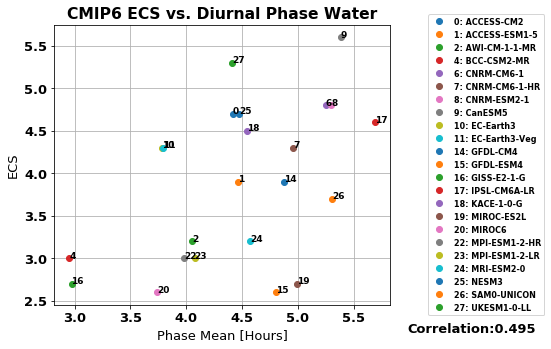

In [345]:
metric_scatter(model_error_stats_df,  y_field = 'ecs', x_field = 'phase_mean')
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)




0.49527914554869934


(2.5, 4.5)

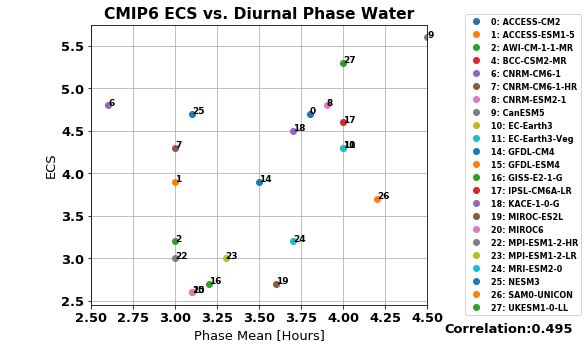

In [351]:
metric_scatter(model_error_stats_df,  y_field = 'ecs', x_field = 'phase_mean')
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)




-0.9643358090777581


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Phase Water')

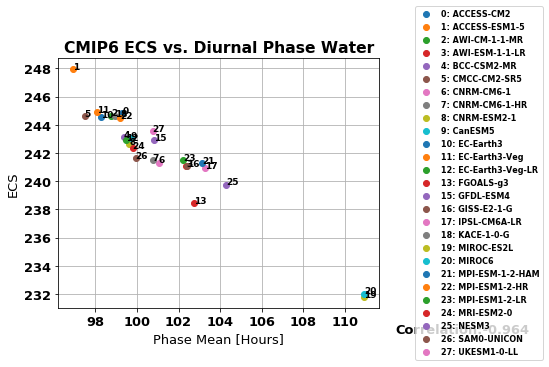

In [53]:
metric_scatter(model_error_stats_df,  y_field = 'rlut', x_field = 'rsut')
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)





0.808681897025706


Text(0.5, 1, 'CMIP6 ECS vs. TCR')

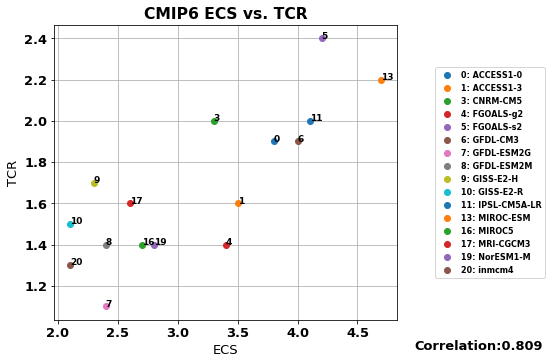

In [146]:
metric_scatter(model_error_stats_df_water, x_field = 'ecs', y_field = 'tcr' )
plt.xlabel('ECS')
plt.ylabel('TCR')
plt.title('CMIP6 ECS vs. TCR', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/' + 'ecs_vs_tcr_cmip6.png',  dpi = 300)



In [455]:
# # fig, ax = plt.subplots()
# plt.figure(figsize = (7,5))
# # for mod_ii in model_error_stats_df.iterrows():
# model_list = list(model_error_stats_df.index)
# for ii in range(len(model_error_stats_df)):
#     mod_ii = model_error_stats_df.iloc[ii,:]
#     xx,yy = mod_ii[x_field], mod_ii[y_field]
#     if (not np.isnan(xx)) & (not np.isnan(yy)):
# #         print(xx,yy)
#         plt.plot(xx, yy, 'o', label = str(ii) + ': ' + model_list[ii])
#         plt.annotate(str(ii), (xx, yy), size = 9, weight = 'bold')
# plt.grid()
# plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5),prop={'size': 8})
# plt.xlabel('Phase Mean')
# plt.ylabel('ECS')
# plt.tight_layout()

In [456]:
model_error_stats_df.corr()

0.5673670369844968

In [43]:
# np.corrcoef
# model_error_stats
# plt.imshow(df_i[field].values * (2*np.pi/24), origin = 'lower')
def sin_hour(hours):
    '''Give array of hours, convert sin quanitity to deal with cirular quantity'''
    return np.sin(hours*HOURS_TO_RADIANS)
# df_i[field].values * HOURS_TO_RADIANS

In [370]:
# xx = np.arange(0, 24,0.01)
# plt.plot(xx, sin_hour(xx))

In [371]:
# _ = plt.hist(sin_hour(df[df['model_name'] == model_name][field].values), bins = 200)

In [372]:
# sin_hour(6)

In [373]:
# _ = plt.hist(df[df['model_name'] == model_name][field].values, bins =200)

array([[ 1.        , -0.53193993],
       [-0.53193993,  1.        ]])

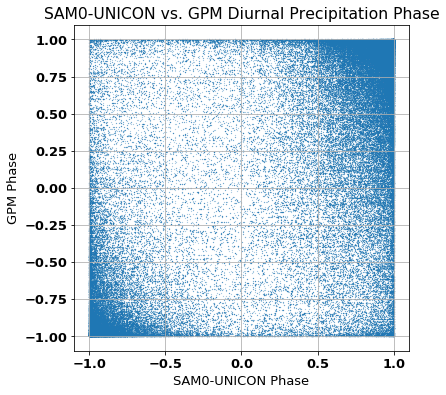

In [356]:
field = 'phase_season'
model_name = 'SAM0-UNICON'
plt.figure(figsize = (6,6))
plt.scatter(sin_hour(df[df['model_name'] == model_name][field].values), 
            sin_hour(df_gpm[field].values), 
            s=0.02)
plt.xlabel(model_name + ' Phase')
plt.ylabel('GPM Phase')
plt.title( model_name + ' vs. GPM Diurnal Precipitation Phase')
plt.grid()
np.corrcoef(sin_hour(df[df['model_name'] == model_name][field].values), df_gpm[field].values)
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'sample_scatter_phases.png', dpi = 300)

array([[ 1.        , -0.25302769],
       [-0.25302769,  1.        ]])

In [70]:
# df.groupby('season')

In [185]:
# Create Taylor Diagram
# import taylorDiagram
# %%capture
%run taylorDiagram.py

In [245]:
df

mu_season  sigma_season  ampl_season  phase_season  \
lat   lon                                                         
-60.0 0.0     0.000017      0.000001     0.000002      0.524775   
      0.0     0.000030      0.000002     0.000003      2.190587   
      0.0     0.000032      0.000002     0.000002      2.044747   
      0.0     0.000027      0.000001     0.000001     21.782672   
      0.0     0.000024      0.000002     0.000002      0.660006   
...                ...           ...          ...           ...   
 59.5 359.5   0.000039      0.000002     0.000002     23.090859   
      359.5   0.000034      0.000002     0.000002      2.330588   
      359.5   0.000041      0.000003     0.000004      2.125144   
      359.5   0.000037      0.000003     0.000003      1.820820   
      359.5   0.000031      0.000003     0.000003      1.394879   

                model_name cmip_indentifier  land_sea_mask  
lat   lon                                                   
-60.0 0.0        FGOALS-g2            CMIP5              0  
      0.0           MIROC5            CMIP5              0  
      0.0           inmcm4            CMIP5              0  
      0.0          MIROC4h            CMIP5              0  
      0.0          CMCC-CM            CMIP5              0  
...                    ...              ...            ...  
 59.5 359.5    SAM0-UNICON            CMIP6              0  
      359.5         MIROC6            CMIP6              0  
      359.5  ACCESS-ESM1-5            CMIP6              0  
      359.5     ACCESS-CM2            CMIP6              0  
      359.5          NESM3            CMIP6              0  

[6048000 rows x 7 columns]

In [248]:
# gpm_std
sorted(df[df['cmip_indentifier'] == 'CMIP6']['model_name'].unique())

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-MR',
 'CMCC-CM2-SR5',
 'EC-Earth3',
 'EC-Earth3-Veg-LR',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'SAM0-UNICON']

In [227]:
model_error_stats.head()

,std,corr,rmse,ampl_mean,phase_mean,ecs
ACCESS-CM2,4.980532,0.194987,6.495437,0.036648,13.152773,4.7
ACCESS-ESM1-5,3.295360,0.211391,6.934853,0.054257,12.834726,3.9
AWI-CM-1-1-MR,2.778771,0.196295,7.022509,0.060849,12.878386,3.2
AWI-ESM-1-1-LR,2.797228,0.178002,6.945988,NaN,NaN,NaN
BCC-CSM2-MR,5.775114,0.221402,6.635449,0.021344,12.312652,3.0


In [242]:
# model_error_stats['ACCESS-CM2']
model_error_stats.loc["ACCESS-CM2",:]
# model_error_stats.index[0]

std            4.980532
corr           0.194987
rmse           6.495437
ampl_mean      0.036648
phase_mean    13.152773
ecs            4.700000
Name: ACCESS-CM2, dtype: float64

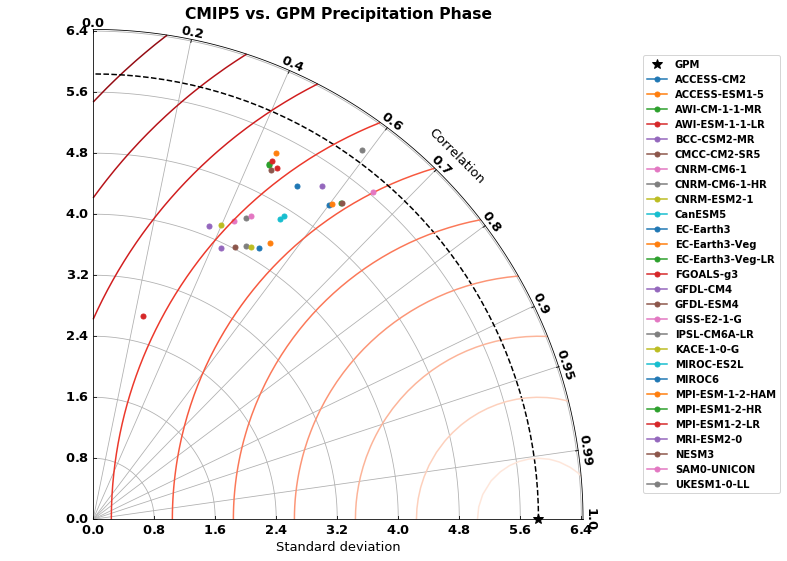

In [354]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP5 vs. GPM Precipitation Phase', weight = 'bold')
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_water.png', dpi = 300)

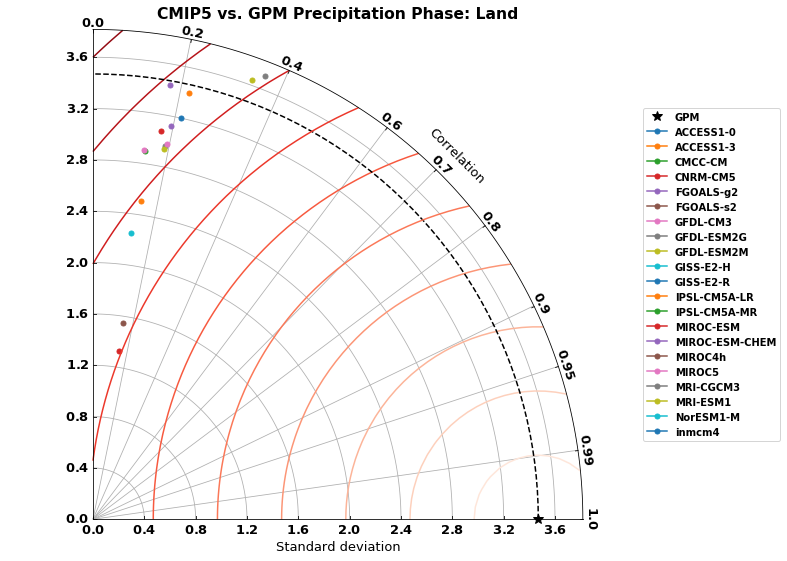

In [150]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_land_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_land.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_land.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_land.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP5 vs. GPM Precipitation Phase: Land', weight = 'bold')
plt.tight_layout()

plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_land.png', dpi = 300)

2.6193638396735426

NameError: name 'model_error_stats_df_water' is not defined

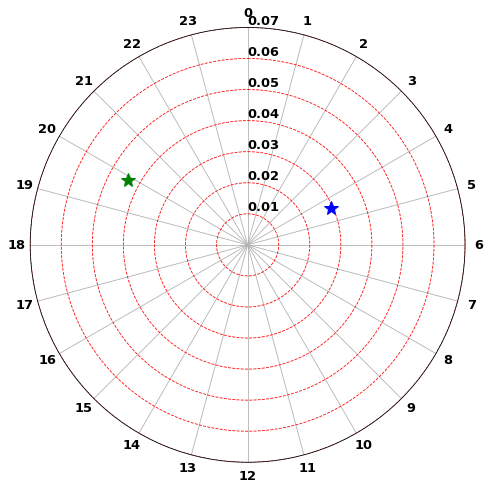

In [355]:
%run phaseDiagram.py

fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = PhaseDiagram(gpm_water_std, 
                          fig = fig, 
                          label = 'GPM', 
                          y_lim=(0, 0.07),
                          radial_label_pos = 0
                          )
taylor_diag.add_grid()

taylor_diag.add_sample(phase = phase_circmean(df_for_stats_true_water['phase_season']), 
                           ampl = df_for_stats_true_water['ampl_season'].mean(), 
                           marker = '*', 
                           c = 'b',
                           label = 'GPM-Water', 
                           markersize = 15)

taylor_diag.add_sample(phase = phase_circmean(df_for_stats_true_land['phase_season']), 
                           ampl = df_for_stats_true_land['ampl_season'].mean(), 
                           marker = '*', 
                           c = 'g',
                           label = 'GPM-Land', 
                           markersize = 15)

# plot model points 
model_list = list(model_error_stats_df_water.index)
for model_name_i in range(len(model_list)):
#     print(model_error_stats[model_name])
#     print(model_error_stats_df.loc[model_name,:]['phase_mean'])
    phase_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['ampl_mean']

    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None,
                           linestyle = None,
                           c = 'b',
                           label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           markersize = 1)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         label = str(model_name_i) + ': ' + model_list[model_name_i], 
                         c = 'b',
                         size = 7,
                         weight = 'bold')
    
for model_name_i in range(len(model_list)):

    phase_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['ampl_mean']

    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None, 
                           c = 'g',
                           linestyle = None,
#                            label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           label = None,
                           markersize = 1)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         c = 'g',
                         size = 9,
                         weight = 'bold')


# plt.legend()
leg = plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
# for n, text in enumerate(leg.markerscale):
#     print( n, text)
#     text.set_color( color_l[n] )

plt.title(r'Diurnal Phase [hr] & Amplitude [$\frac{mm}{hr}$] : CMIP5 vs. GPM over Land and Water', weight = 'bold')
plt.tight_layout()

# plt.savefig(save_figs_dir + 'phase_ampl_plots/' + 'all_cmip5_land_water.png', dpi = 300)

In [424]:
leg.markerscale

1.0

In [422]:
leg.

In [324]:
axx = taylor_diag.get_ax()

In [325]:
axx.

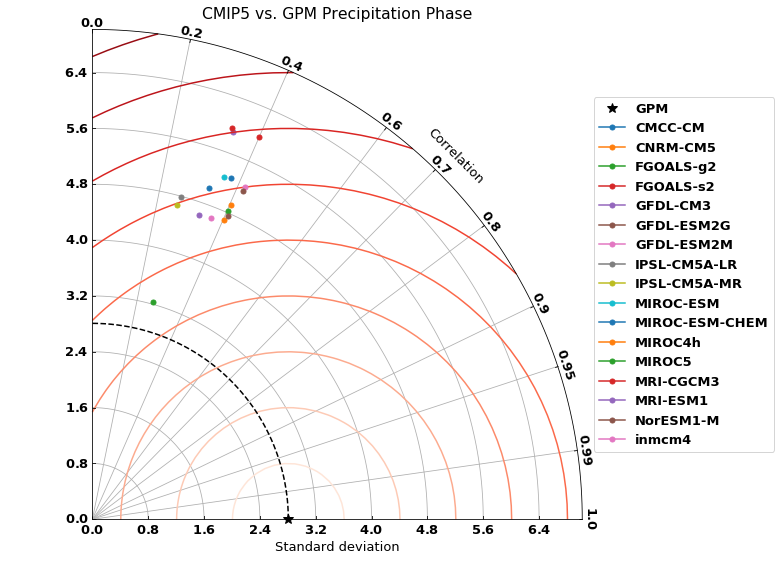

In [165]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM',
                                           srange=(0, 2.5))
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats.keys()):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats[model_name][0], 
                           corrcoef = model_error_stats[model_name][1], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1,0.5))

plt.title('CMIP5 vs. GPM Precipitation Phase')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5.png', dpi = 300)